In [1]:
#调用的包信息
import re  
import pickle
import random
import pandas as pd
import numpy as np
import jieba

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.model_selection import train_test_split

In [3]:
with open('京东评论数据.csv', encoding='utf-8') as f:
    data = pd.read_csv(f)

In [4]:
def DataOverview(data):
    print('Data Overview:')
    print(data.head(4))
    print('-'*30)
    print('Data Information')
    print(data.info())
    print('-'*40)
    print('Data DESC:')
    print(data.describe())
    print('-'*60)

DataOverview(data)

Data Overview:
    sku_id                                   _id item_name   comment_id  \
0  7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment  11801751173   
1  7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment  11525358140   
2  7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment  11787681311   
3  8240587  082df194-97f0-425e-85ac-8596344114e6   comment  11726613552   

                                             content        creation_time  \
0                                 还可以刷脸解锁，帮朋友买的，她很满意  2018-08-13 12:24:59   
1  第一次买vivo，真心不错，1498的机子，没想到照相很清晰，性价比很高，买值了，还送了小音...  2018-05-27 17:49:17   
2                                         手机好用快递送的快。  2018-08-09 07:17:37   
3  手机收到。外观设计很好！美观大方。我喜欢！一直使用华为手机。从荣耀七，荣耀八，荣耀九。反正一...  2018-07-21 13:29:44   

   reply_count  score  useful_vote_count  useless_vote_count  ...  \
0            0      5                  0                   0  ...   
1            7      5                 19                   0  ...   
2            0  

In [5]:
#缺失值审核
def MissingView(data):
    na_cols = data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
    print ('NA Cols:')
    print (na_cols)  # 查看具有缺失值的列
    print ('-' * 30)
    na_lines = data.isnull().any(axis=1)  # 查看每一行是否具有缺失值
    print ('NA Recors:')
    print ('Total number of NA lines is: {0}'.format(na_lines.sum()))  # 查看具有缺失值的行总记录数
    print (data[na_lines])  # 只查看具有缺失值的行信息
    print ('-' * 60)
    
MissingView(data)

NA Cols:
sku_id                False
_id                   False
item_name             False
comment_id            False
content               False
creation_time         False
reply_count           False
score                 False
useful_vote_count     False
useless_vote_count    False
user_level_id         False
user_province          True
nickname              False
user_level_name       False
user_client           False
user_client_show       True
is_mobile              True
days                   True
reference_time         True
after_days             True
after_user_comment     True
dtype: bool
------------------------------
NA Recors:
Total number of NA lines is: 3637
           sku_id                                   _id item_name  \
0         7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment   
1         7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment   
2         7534113  03b51aa9-2b5e-41c3-a40b-343164a1d23a   comment   
3         8240587  082df194-97f0-425e-8

<Axes: xlabel='score', ylabel='count'>

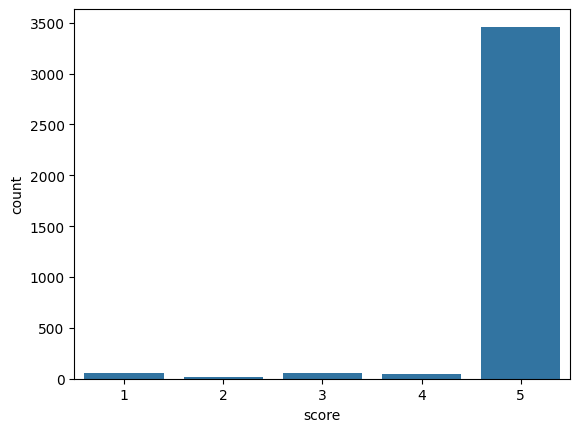

In [6]:
data['score'].value_counts()
sns.countplot(data=data,x='score')

In [7]:
#数据转化
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['reference_time'] = pd.to_datetime(data['reference_time'])

data['year'] = data.creation_time.dt.year
data['month'] = data.creation_time.dt.month
data['weekday'] = data.creation_time.dt.weekday
data['hour'] = data.creation_time.dt.hour

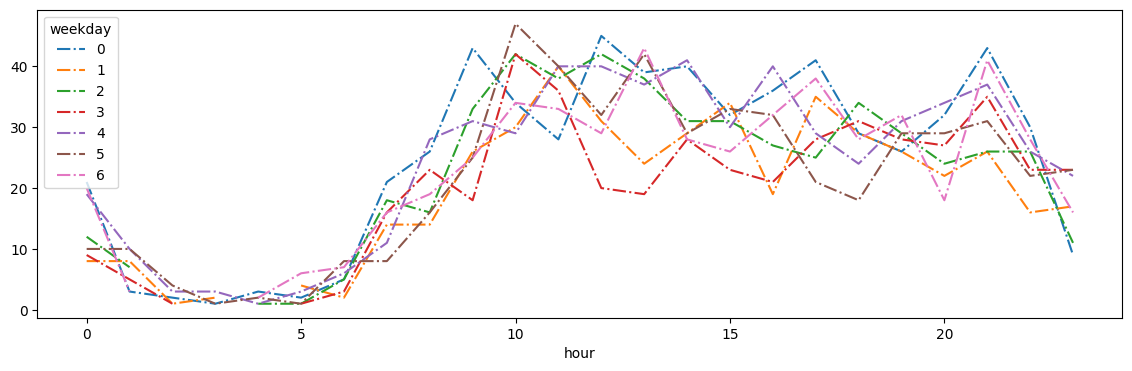

In [8]:
#观测每周评论数数据变化情况
fig1, ax1=plt.subplots(figsize=(14,4))
df=data.groupby(['hour', 'weekday']).count()['nickname'].unstack()
df.plot(ax=ax1, style='-.')
plt.show()

(0.0, 600.0)

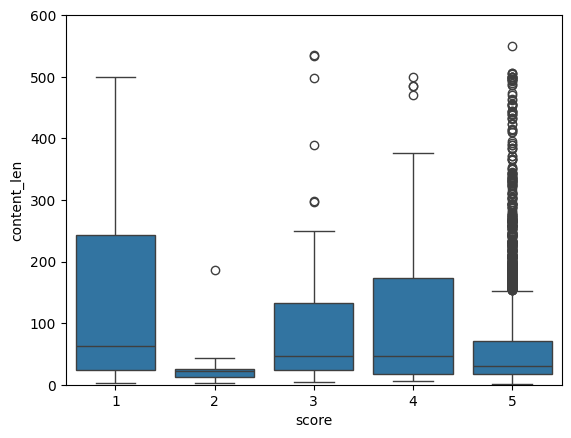

In [9]:
#评论的长短可以看出评论者的认真程度
data['content_len'] = data['content'].str.len()
fig2, ax2=plt.subplots()
sns.boxplot(x='score',y='content_len',data=data, ax=ax2)
ax2.set_ylim(0,600)

In [39]:
#提取需处理的数据及标签
data1 = data[['content', 'score']]
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637 entries, 0 to 3636
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  3637 non-null   object
 1   score    3637 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.0+ KB


In [41]:
data1

,content,score
0,还可以刷脸解锁，帮朋友买的，她很满意,5
1,第一次买vivo，真心不错，1498的机子，没想到照相很清晰，性价比很高，买值了，还送了小音...,5
2,手机好用快递送的快。,5
3,手机收到。外观设计很好！美观大方。我喜欢！一直使用华为手机。从荣耀七，荣耀八，荣耀九。反正一...,5
4,收到了，挺好的，声音大，电池大，好用发货速度快，非常满意，好好好。,5
...,...,...
3632,经常用小米的手机，红米小米各类品牌买了好多个。红米6，这款手机配置好，运行很流畅，比我的小米...,5
3633,特别，手机电池抗用，屏幕没有划痕，这次购物非常满意,5
3634,先用着，暂时不错。没有问题。,5
3635,手机拍照不清晰，很朦,5


In [ ]:
#获取停用词
with open(r'哈工大停用词表.txt', encoding='utf-8') as file:
    word_list = [x.strip() for x in file.readlines()]

def SetLabel(score):
    if score >=4:
        return 1 
    else:
        return 0
    
data1['score'] = data1['score'].map(lambda x:SetLabel(x))

# 分词函数
data1['seg_words'] = data1['content'].apply(lambda x: ' '.join(jieba.cut(x)))


#数据集拆分为语料、标签
terms = data1['seg_words'].tolist()
y = data1['score'].tolist()

from sklearn.feature_extraction.text import TfidfVectorizer as TFIV

# 初始化TFIV对象，去停用词，加2元语言模型
tfv = TFIV(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
           ngram_range=(1, 2), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words=word_list)  

tfv.fit(terms)
X_all = tfv.transform(terms)



#特征选择
from sklearn.feature_selection import SelectKBest, chi2
select_feature_model = SelectKBest(chi2, k=100)    ##卡方检验来选择100个最佳特征
X_all = select_feature_model.fit_transform(X_all, y)  #减少特征的数量，达到降维的效果，从而使模型的方法能力更强，降低过拟合的风险

#切分测试集、训练集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_all, y, random_state=0, test_size=0.25)

model_NB = MNB()
model_NB.fit(x_train, y_train) #特征数据直接灌进来
MNB(alpha=1.0, class_prior=None, fit_prior=True) # ”alpha“是平滑参数，不需要掌握哈。

from sklearn.model_selection import cross_val_score
#评估预测性能，减少过拟合
print("贝叶斯分类器20折交叉验证得分: ", np.mean(cross_val_score(model_NB, x_train, y_train, cv=20, scoring='roc_auc')))

贝叶斯分类器20折交叉验证得分:  0.42279435577145497


In [26]:
from sklearn.metrics import confusion_matrix
y_predict = model_NB.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
cm

array([[  0,  26],
       [  0, 884]])

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 数据准备
terms = data1['seg_words'].tolist()
y = data1['score'].tolist()

# 将文本数据转换为TF-IDF特征
tfv = TfidfVectorizer(min_df=3, max_features=5000, strip_accents='unicode', analyzer='word', 
                      token_pattern=r'\w{1,}', ngram_range=(1, 2), use_idf=True, smooth_idf=True, 
                      sublinear_tf=True, stop_words=word_list)

X = tfv.fit_transform(terms).toarray()  # 将TF-IDF结果转为数组

# 数据标准化（有助于神经网络收敛）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 建立神经网络模型
model = Sequential()

# 添加输入层和隐藏层
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))  # 512个神经元的隐藏层
model.add(Dropout(0.5))  # Dropout层，避免过拟合
model.add(Dense(256, activation='relu'))  # 256个神经元的隐藏层
model.add(Dropout(0.5))

# 添加输出层
model.add(Dense(1, activation='sigmoid'))  # 如果是回归问题，可以改为linear激活函数

# 编译模型
model.compile(loss='binary_crossentropy',  # 如果是回归问题，使用mean_squared_error
              optimizer='adam',
              metrics=['accuracy'])

# 训练模型
history = model.fit(X_train, np.array(y_train), epochs=10, batch_size=64, validation_data=(X_test, np.array(y_test)))

# 评估模型
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# 使用模型进行预测
y_pred = model.predict(X_test)


/Users/damon/PythonVenvs/bigdataProject/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1a', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1o', '2', '21', '210', '22', '23', '24', '25', '26', '27', '28', '2a', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '3', '31', '310', '3a', '3b', '3c', '3d', '3e', '3f', '3g', '3h', '4', '4a', '4b', '4c', '4d', '4e', '5', '5a', '5b', '5d', '5e', '5f', '6', '7', '8', '9', 'C', '_', 'a', 'b', 'c', 'e', 'f', 'iii', 'l', 'lex', 'li', 'ng昉', 'r', 'zxfitl', 'β', 'δ', 'λ', 'ξ', 'ψ', 'в', '元', '八', '吨', '数', '日', '末'] not in stop_words.
  warnings.warn(


Epoch 1/10


/Users/damon/PythonVenvs/bigdataProject/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9045 - loss: 0.3920 - val_accuracy: 0.9643 - val_loss: 0.1566
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9696 - loss: 0.1088 - val_accuracy: 0.9629 - val_loss: 0.1570
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9784 - loss: 0.0575 - val_accuracy: 0.9560 - val_loss: 0.1609
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9956 - loss: 0.0162 - val_accuracy: 0.9629 - val_loss: 0.2122
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9970 - loss: 0.0186 - val_accuracy: 0.9437 - val_loss: 0.2323
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9975 - loss: 0.0099 - val_accuracy: 0.9574 - val_loss: 0.2368
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9979 - loss: 0.0122 - val_accuracy: 0.9478 - val_loss: 0.2586
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9982 - loss: 0.0101 - val_accuracy: 0.9505 - val_loss: 0.

In [38]:
import jieba
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import load_model  # 假设你已经保存了训练好的模型
import tensorflow as tf

# 加载训练好的模型
# model = load_model('path_to_your_trained_model.h5')

# 假设已经有训练好的 TF-IDF 矩阵转换器
# tfv = TfidfVectorizer(min_df=3, max_features=5000, strip_accents='unicode', analyzer='word', 
#                       token_pattern=r'\w{1,}', ngram_range=(1, 2), use_idf=True, smooth_idf=True, 
#                       sublinear_tf=True, stop_words=word_list)

# 假设你已经训练过了 TF-IDF，下面使用该转换器来进行预测

# 输入的中文文本
input_text = "差评"

# 1. 分词
def chinese_cut(text):
    return " ".join(jieba.cut(text))

# 2. 文本预处理：分词并转换为TF-IDF特征
seg_text = chinese_cut(input_text)  # 分词
X_input = tfv.transform([seg_text]).toarray()  # 转换为TF-IDF特征

# 3. 使用模型进行预测（假设你是二分类问题）
y_pred_prob = model.predict(X_input)  # 返回预测概率

# 4. 根据概率进行分类（假设是二分类，阈值为0.5）
y_pred_label = (y_pred_prob > 0.5).astype(int)  # 0为差评，1为好评
print(y_pred_prob)
# 输出预测结果
if y_pred_label == 1:
    print("预测结果：好评")
else:
    print("预测结果：差评")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.5307586]]
预测结果：好评


In [47]:
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

# 1. 数据加载
data = pd.DataFrame({
    "content": [
        "第一次买vivo，真心不错，性价比很高，买值了。",
        "手机收到。外观设计很好！我喜欢！",
        "经常用小米的手机，红米性价比非常高。",
        "特别，手机电池抗用，这次购物非常满意。",
        "这个手机真的很差，用了一天就卡了，失望！",
        "外壳设计不行，按键很松动，用起来很别扭。",
        "性价比真的很高，运行流畅，发货速度快！",
        "垃圾手机，拍照像素很差，用一天就坏了。",
        "买给朋友的，朋友很满意，说很流畅！",
        "发货速度很慢，客服态度也不好，不满意。"
    ],
    "score": [5, 5, 5, 5, 1, 2, 5, 1, 5, 2]
})

# 2. 数据预处理
# 根据 score 划分情感（例如：1~2 为差评，3 为中评，4~5 为好评）
def sentiment_label(score):
    if score >= 4:
        return 2  # 好评
    elif score == 3:
        return 1  # 中评
    else:
        return 0  # 差评

data["sentiment"] = data["score"].apply(sentiment_label)

# 分词
def chinese_cut(text):
    return " ".join(jieba.cut(text))

data["content_cut"] = data["content"].apply(chinese_cut)

# 3. 准备数据集
X = data["content_cut"].values
y = data["sentiment"].values

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Tokenizer 和序列化
tokenizer = Tokenizer(num_words=5000)  # 最多保留 5000 个词
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 填充序列，使所有序列长度相同
maxlen = 50  # 句子最大长度（可以根据需要调整）
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post")

# 5. 构建神经网络模型（LSTM）
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=maxlen),  # 词嵌入层
    Bidirectional(LSTM(64, return_sequences=False)),  # 双向 LSTM
    Dropout(0.5),  # 防止过拟合
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 输出层（3 类：好评、中评、差评）
])

# 6. 编译模型
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # 多分类交叉熵
    metrics=['accuracy']
)

# 7. 模型训练
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

# 8. 模型评估
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"测试集准确率：{accuracy:.2f}")

# 9. 单条预测
def predict_sentiment(text):
    text_cut = chinese_cut(text)
    text_seq = tokenizer.texts_to_sequences([text_cut])
    text_pad = pad_sequences(text_seq, maxlen=maxlen, padding="post")
    prediction = model.predict(text_pad)
    sentiment = np.argmax(prediction, axis=1)[0]
    print(sentiment)
    sentiment_map = {0: "差评", 1: "中评", 2: "好评"}
    return sentiment_map[sentiment]

# 测试单条数据
test_text = "真好！"
print("预测结果：", predict_sentiment(test_text))


Epoch 1/10


/Users/damon/PythonVenvs/bigdataProject/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6667 - loss: 1.0872 - val_accuracy: 0.0000e+00 - val_loss: 1.0992
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6667 - loss: 1.0547 - val_accuracy: 0.0000e+00 - val_loss: 1.1071
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6667 - loss: 1.0227 - val_accuracy: 0.0000e+00 - val_loss: 1.1159
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6667 - loss: 0.9794 - val_accuracy: 0.0000e+00 - val_loss: 1.1341
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6667 - loss: 0.9288 - val_accuracy: 0.0000e+00 - val_loss: 1.1679
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6667 - loss: 0.8535 - val_accuracy: 0.0000e+00 - val_loss: 1.2184
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6667 - loss: 0.8615 - val_accuracy: 0.0000e+00 - val_loss: 1.2884
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6667 - loss: 0.7852 - val_accuracy: 0.0000e+00

In [1]:
import datetime
import pandas as pd 

df = pd.read_csv("/Users/damon/Desktop/jdComment/datasets/训练集.csv")

def convert_to_2024(timestamp):
    dt_object = datetime.datetime.fromtimestamp(timestamp)
    dt_object_2024 = dt_object.replace(year=2024)
    return dt_object_2024

df['评论时间'] = df['评论时间戳'].apply(convert_to_2024)
df['评价标签'] = df['评分'].apply(lambda x: '好评' if x > 3 else ('中评' if x == 3 else '差评'))


In [15]:
df = df[['数据ID', '用户ID', '商品ID', '评论时间戳', '评论时间', '评论标题', '评论内容', '评分', '评价标签']]

In [16]:
df.columns = ["data_id", "user_id", "product_id", "review_timestamp", "review_time", "review_title", "review_content", "rating", "label"]


In [3]:
df["评论内容"]

0        刚刚收到,2天我晕,一般快递最快到我们这要3天呢,赞个!!!   包装台简单了,说明书看不懂...
1                   不过这本书没有赠送什么代金券。体现不出以前的正版图书送网站学习代金券的特点。
2                             很负责任的说一句,亚马逊给我发过来的手机绝对是二手的!!
3                    这本书内容很好,就是送的光盘不行。这次重新订购了一套,期望发过来的光盘能用
4                                            很实用的一本书,非常喜欢!
                               ...                        
69995                                就是纸张有的地方脏脏的。书不错,文章很多。
69996                        买给我妈看的,也不知道好不好。但是里面的衣服是真的挺漂亮的
69997                                       质量好,书也很好,就是太难了
69998    看到就迷上了,让人有一股无法言语的就沉浸的魔力。买回来就迫不及待的看完了,还想一口气把她其他...
69999                      包装还好,歌曲间隔之间总是有空壳摩擦的声音,不会是盗版吧!!!
Name: 评论内容, Length: 70000, dtype: object

In [18]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# 下载NLTK的停用词和tokenize库
nltk.download('punkt')
nltk.download('stopwords')

comments = comments.str.lower()

# 2. 去除标点符号和数字
comments = comments.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# 3. 去除停用词
stop_words = set(stopwords.words('english'))  # 对于中文可以选择中文停用词表
comments_cleaned = comments.apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

# 示例：查看处理后的第一条评论
print(comments_cleaned.iloc[0])


In [7]:
comments = df['评论内容']

In [4]:
# 加载哈工大停用词表
file_path = "/Users/damon/Desktop/jdComment/哈工大停用词表.txt"
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set([line.strip() for line in f.readlines()])
    return stopwords

stopwords = load_stopwords(file_path)


In [ ]:
import jieba
from collections import Counter

file_path = "/Users/damon/Desktop/jdComment/哈工大停用词表.txt"
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set([line.strip() for line in f.readlines()])
    return stopwords

def preprocess_text(text, stopwords):
    words = jieba.cut(text)
    return [word for word in words if word not in stopwords and len(word) > 1]


stopwords = load_stopwords(file_path)

comments_cleaned = comments.apply(lambda x: preprocess_text(x, stopwords))

all_words = [word for comment in comments_cleaned for word in comment]
word_counts = Counter(all_words)
word_counts.most_common(10)


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/c5/h650sxfn083d23_bbhv6n8tw0000gn/T/jieba.cache
Loading model cost 0.318 seconds.
Prefix dict has been built successfully.


['刚刚', '收到', '快递', '最快', '这要', '赞个', '包装', '简单', '说明书', '看不懂', '瓶子', '半透明', '官方', '卓越', '合作伙伴', '正品', '放心']


In [ ]:
from collections import Counter

all_words = [word for comment in comments_cleaned for word in comment]
word_counts = Counter(all_words)

print(word_counts.most_common(10))


[('不错', 17732), ('喜欢', 10086), ('本书', 8568), ('没有', 8002), ('内容', 7878), ('质量', 6816), ('感觉', 6140), ('非常', 5018), ('比较', 4618), ('有点', 4348)]


In [12]:
[{"name": word, "value": count} for word, count in word_counts.most_common(10)]


[{'name': '不错', 'value': 17732},
 {'name': '喜欢', 'value': 10086},
 {'name': '本书', 'value': 8568},
 {'name': '没有', 'value': 8002},
 {'name': '内容', 'value': 7878},
 {'name': '质量', 'value': 6816},
 {'name': '感觉', 'value': 6140},
 {'name': '非常', 'value': 5018},
 {'name': '比较', 'value': 4618},
 {'name': '有点', 'value': 4348}]

In [2]:
pip install geopy

Looking in indexes: http://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
